# The Problem

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
%matplotlib inline 
plt.style.use('fivethirtyeight')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [59]:
pima_column_names = ['times_pregnant', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 'triceps_thickness', 'serum_insulin', 'bmi', 'pedigree_function', 'age', 'onset_diabetes']
pima = pd.read_csv(r'F:\Datasets\end_to_end_data_sets\end to end data sets\diabetes.csv',names = pima_column_names,skiprows=1)
pima.head()


,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [60]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   times_pregnant                767 non-null    int64  
 1   plasma_glucose_concentration  767 non-null    int64  
 2   diastolic_blood_pressure      767 non-null    int64  
 3   triceps_thickness             767 non-null    int64  
 4   serum_insulin                 767 non-null    int64  
 5   bmi                           767 non-null    float64
 6   pedigree_function             767 non-null    float64
 7   age                           767 non-null    int64  
 8   onset_diabetes                767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Exploratory data analysis (EDA)
To identify our missing values we will begin with an EDA of our dataset. We will be using some useful python packages, pandas and numpy, to store our data and make some simple calculations as well as some popular visualization tools to see what the distribution of our data looks like. Let's begin and dive into some code. First, we will do some imports:

In [61]:
pima['onset_diabetes'].value_counts(normalize=True) 

0    0.65189
1    0.34811
Name: onset_diabetes, dtype: float64

If our eventual goal is to exploit patterns in our data in order to predict the onset of diabetes, let us try to visualize some of the differences between those that developed diabetes and those that did not. Our hope is that the histogram will reveal some sort of pattern, or obvious difference in values between the classes of prediction

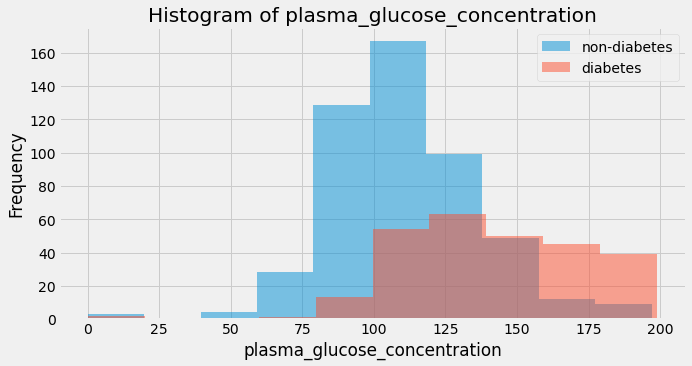

In [62]:
col = 'plasma_glucose_concentration'
plt.figure(figsize=(10,5))
plt.hist(pima[pima['onset_diabetes']==0][col], 10, alpha=0.5, label='non-diabetes')
plt.hist(pima[pima['onset_diabetes']==1][col], 10, alpha=0.5, label='diabetes')
plt.legend(loc='upper right')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(col))
plt.show()

It seems that this histogram is showing us a considerable difference between plasma_glucose_concentration between the two prediction classes. Let's show the same histogram style for multiple columns as follows

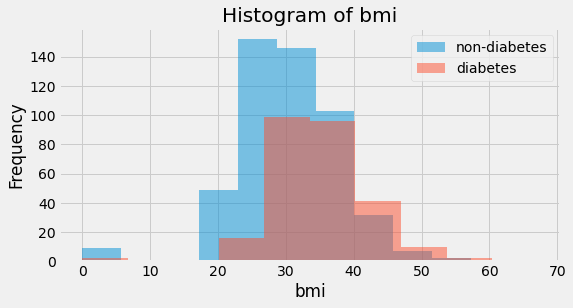

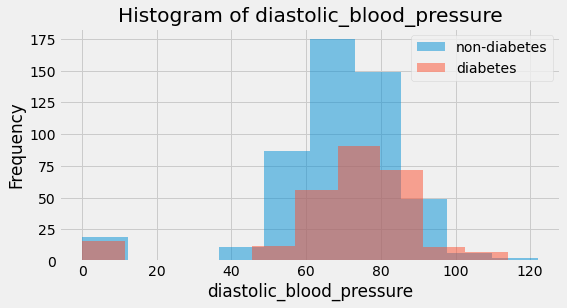

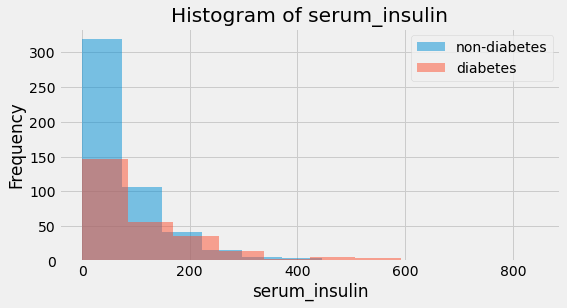

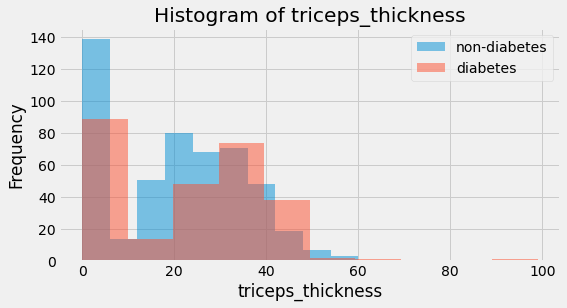

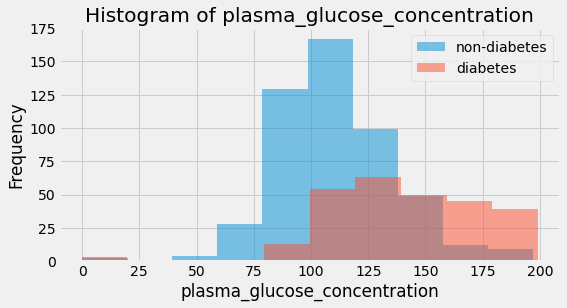

In [63]:
for col in ['bmi', 'diastolic_blood_pressure', 'serum_insulin','triceps_thickness', 'plasma_glucose_concentration']:
    plt.figure(figsize=(8,4))
    plt.hist(pima[pima['onset_diabetes']==0][col], 10, alpha=0.5, label='non-diabetes')
    plt.hist(pima[pima['onset_diabetes']==1][col], 10, alpha=0.5, label='diabetes')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

We can definitely see some differences simply by looking at just a few histograms. For example, there seems to be a large jump in plasma_glucose_concentration for those who will eventually develop diabetes. To solidify this, perhaps we can visualize a linear correlation matrix in an attempt to quantify the relationship between these variables. 

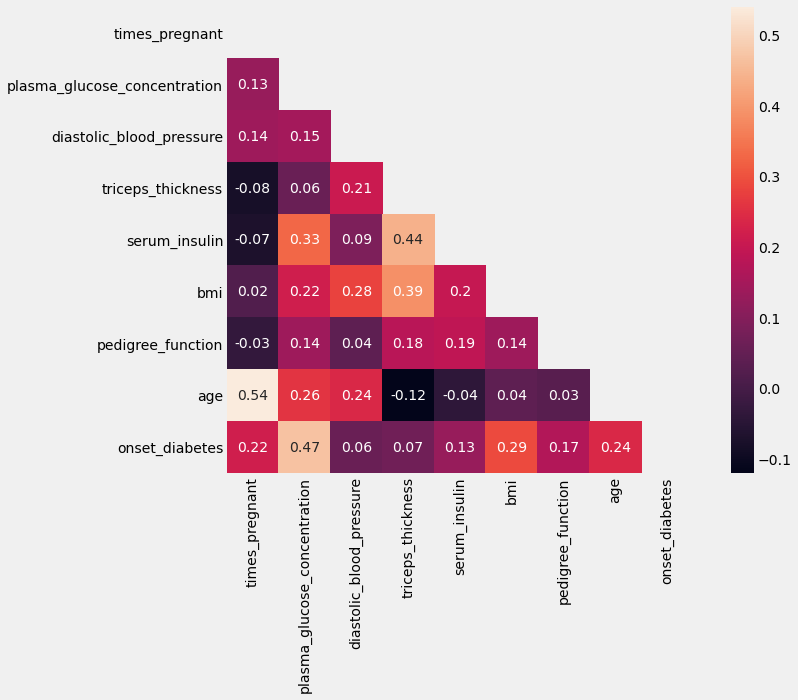

In [64]:
# look at the heatmap of the correlation matrix of our dataset
plt.figure(figsize=(12,8))
corr=round(pima.corr(),2)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr,mask=mask, square=True, annot=True)
plt.xticks(rotation=90)
plt.show()
# plasma_glucose_concentration definitely seems to be an interesting feature here

#Following is the correlation matrix of our dataset. This is showing us the correlation amongst 
#the different columns in our Pima dataset. The output is as follows:

This correlation matrix is showing a strong correlation between plasma_glucose_concentration and onset_diabetes. Let's take a further look at the numerical correlations for the onset_diabetes column

In [65]:
pima.corr()['onset_diabetes'] 

times_pregnant                  0.221087
plasma_glucose_concentration    0.465856
diastolic_blood_pressure        0.064882
triceps_thickness               0.073265
serum_insulin                   0.131984
bmi                             0.292695
pedigree_function               0.173245
age                             0.236417
onset_diabetes                  1.000000
Name: onset_diabetes, dtype: float64

In [66]:
pima.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.842243,120.859192,69.101695,20.517601,79.903520,31.990482,0.471674,33.219035,0.348110
std,3.370877,31.978468,19.368155,15.954059,115.283105,7.889091,0.331497,11.752296,0.476682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,32.000000,0.371000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,127.500000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


This shows us quite quickly some basic stats such as mean, standard deviation, and some different percentile measurements of our data. But, notice that the minimum value of the BMI column is 0. That is medically impossible; there must be a reason for this to happen. Perhaps the number zero has been encoded as a missing value instead of the None value or a missing cell. Upon closer inspection, we see that the value 0 appears as a minimum value for the following columns:

1. times_pregnant
2. plasma_glucose_concentration
3. diastolic_blood_pressure
4. triceps_thickness
5. serum_insulin
6. bmi
7. onset_diabetes

Because zero is a class for onset_diabetes and 0 is actually a viable number for times_pregnant, we may conclude that the number 0 is encoding missing values for:

1. plasma_glucose_concentration
2. diastolic_blood_pressure
3. triceps_thickness
4. serum_insulin
5. bmi

In [67]:
pima['serum_insulin'] = pima['serum_insulin'].map(lambda x:x if x != 0 else None)
# manually replace all 0's with a None value

pima['serum_insulin'].isnull().sum()

373

In [48]:
pima.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,767.000000,767.000000,767.000000,767.000000,394.000000,767.000000,767.000000,767.000000,767.000000
mean,3.842243,120.859192,69.101695,20.517601,155.548223,31.990482,0.471674,33.219035,0.348110
std,3.370877,31.978468,19.368155,15.954059,118.775855,7.889091,0.331497,11.752296,0.476682
min,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,76.250000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,125.000000,32.000000,0.371000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,190.000000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [68]:
columns = ['bmi', 'plasma_glucose_concentration', 'diastolic_blood_pressure', 'triceps_thickness']

for col in columns:
    pima[col] = pima[col].map(lambda x:x if x != 0 else None)

In [69]:
pima.isnull().sum()

times_pregnant                    0
plasma_glucose_concentration      5
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   373
bmi                              11
pedigree_function                 0
age                               0
onset_diabetes                    0
dtype: int64

In [70]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   times_pregnant                767 non-null    int64  
 1   plasma_glucose_concentration  762 non-null    float64
 2   diastolic_blood_pressure      732 non-null    float64
 3   triceps_thickness             540 non-null    float64
 4   serum_insulin                 394 non-null    float64
 5   bmi                           756 non-null    float64
 6   pedigree_function             767 non-null    float64
 7   age                           767 non-null    int64  
 8   onset_diabetes                767 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [71]:
pima.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,767.000000,762.000000,732.000000,540.000000,394.000000,756.000000,767.000000,767.000000,767.000000
mean,3.842243,121.652231,72.405738,29.142593,155.548223,32.455952,0.471674,33.219035,0.348110
std,3.370877,30.540786,12.390616,10.483667,118.775855,6.929448,0.331497,11.752296,0.476682
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.371000,29.000000,0.000000
75%,6.000000,140.750000,80.000000,36.000000,190.000000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [72]:
pima.head(5)

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
0,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
1,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
2,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
3,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
4,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0


In [73]:
pima['plasma_glucose_concentration'].mean(), pima['plasma_glucose_concentration'].std()


(121.6522309711286, 30.540785965138415)

In [74]:
empty_plasma_index = pima[pima['plasma_glucose_concentration'].isnull()].index
pima.loc[empty_plasma_index]['plasma_glucose_concentration']

74    NaN
181   NaN
341   NaN
348   NaN
501   NaN
Name: plasma_glucose_concentration, dtype: float64

In [75]:
# Will try to impute the missing values from the existing v
def relation_with_output( column ):
    temp = pima[pima[column].notnull()]
    d= temp[[column,'onset_diabetes']].groupby(['onset_diabetes'])[column].apply(lambda x: x.median()).reset_index()
    return d

In [76]:
#lets look relation of missing columns with onset_diabetes
relation_with_output('plasma_glucose_concentration')

,onset_diabetes,plasma_glucose_concentration
0,0,107.0
1,1,140.0


In [77]:
relation_with_output('diastolic_blood_pressure')

,onset_diabetes,diastolic_blood_pressure
0,0,70.0
1,1,75.0


In [78]:
relation_with_output('triceps_thickness')

,onset_diabetes,triceps_thickness
0,0,27.0
1,1,32.0


In [79]:
relation_with_output('serum_insulin')

,onset_diabetes,serum_insulin
0,0,102.5
1,1,169.5


In [80]:
relation_with_output('bmi')

,onset_diabetes,bmi
0,0,30.1
1,1,34.3


There is huge difference in the median values of the missing columns with respect of diabetes or not.

We will try to impute values according to these statistics

In [81]:
pima.isnull().sum()

times_pregnant                    0
plasma_glucose_concentration      5
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   373
bmi                              11
pedigree_function                 0
age                               0
onset_diabetes                    0
dtype: int64

In [82]:
pima.loc[(pima['onset_diabetes'] == 0 ) & (pima['serum_insulin'].isnull()), 'serum_insulin'] = 102.5
pima.loc[(pima['onset_diabetes'] == 1 ) & (pima['serum_insulin'].isnull()), 'serum_insulin'] = 169.5

In [83]:
pima.loc[(pima['onset_diabetes'] == 0 ) & (pima['bmi'].isnull()), 'bmi'] = 30.1
pima.loc[(pima['onset_diabetes'] == 1 ) & (pima['bmi'].isnull()), 'bmi'] = 34.3



In [84]:
pima.loc[(pima['onset_diabetes'] == 0 ) & (pima['triceps_thickness'].isnull()), 'triceps_thickness'] = 27.0
pima.loc[(pima['onset_diabetes'] == 1 ) & (pima['triceps_thickness'].isnull()), 'triceps_thickness'] = 32.0



In [85]:
pima.loc[(pima['onset_diabetes'] == 0 ) & (pima['diastolic_blood_pressure'].isnull()), 'diastolic_blood_pressure'] = 70.0
pima.loc[(pima['onset_diabetes'] == 1 ) & (pima['diastolic_blood_pressure'].isnull()), 'diastolic_blood_pressure'] = 75.0

In [86]:
pima.loc[(pima['onset_diabetes'] == 0 ) & (pima['plasma_glucose_concentration'].isnull()), 'plasma_glucose_concentration'] = 107.0
pima.loc[(pima['onset_diabetes'] == 1 ) & (pima['plasma_glucose_concentration'].isnull()), 'plasma_glucose_concentration'] = 140.0


In [87]:
# fill the column's missing values with the mean of the rest of the column
#pima['plasma_glucose_concentration'].fillna(pima['plasma_glucose_concentration'].mean(), inplace=True)
pima.isnull().sum()

times_pregnant                  0
plasma_glucose_concentration    0
diastolic_blood_pressure        0
triceps_thickness               0
serum_insulin                   0
bmi                             0
pedigree_function               0
age                             0
onset_diabetes                  0
dtype: int64

In [88]:
X = pima.loc[:,:'age']
y = pima['onset_diabetes']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [90]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.8854166666666666

In [91]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.921875

# Standardization and normalization
Up until now, we have dealt with identifying the types of data as well as the ways data can be missing and finally, the ways we can fill in missing data. Now, let's talk about how we can manipulate our data (and our features) in order to enhance our machine pipelines further. So far, we have tried four different ways of manipulating our dataset, and the best cross-validated accuracy we have achieved with a KNN model is .745. If we look back at some of the EDA we have previously done, we will notice something about our features

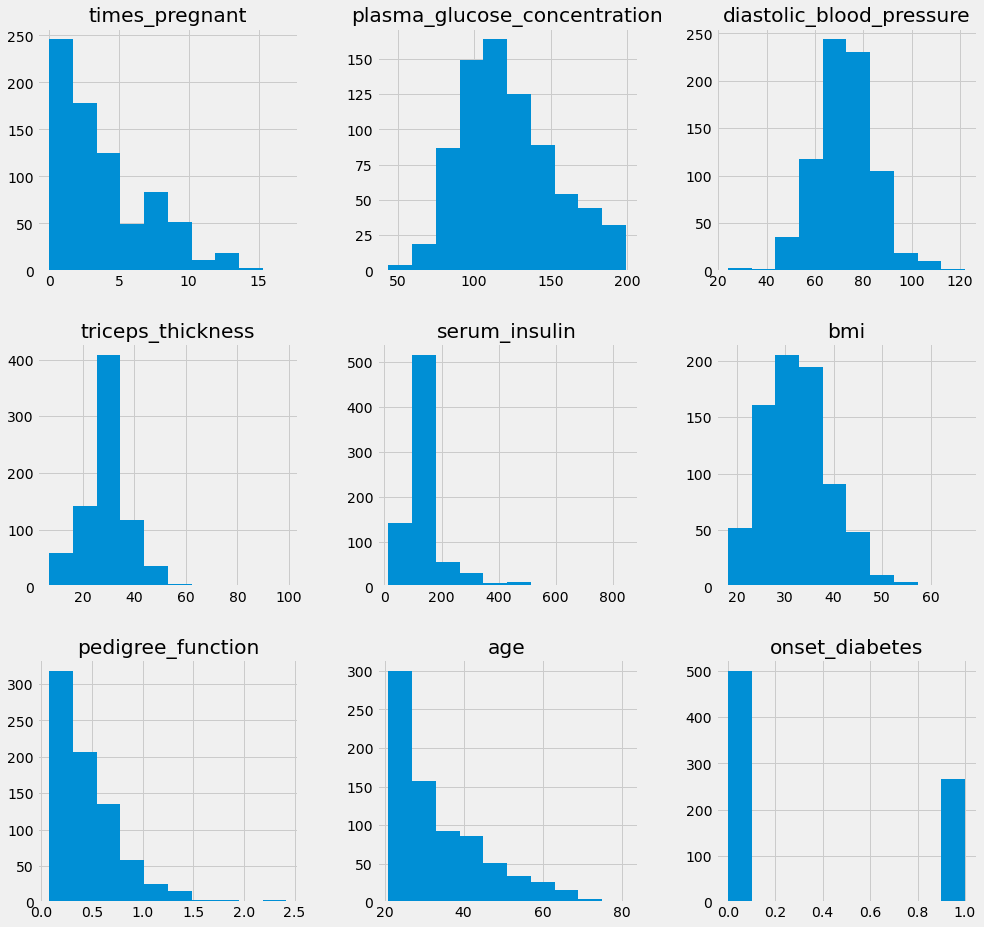

In [92]:
pima.hist(figsize=(15, 15))
plt.show()

In [93]:
pima.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   times_pregnant                767 non-null    int64  
 1   plasma_glucose_concentration  767 non-null    float64
 2   diastolic_blood_pressure      767 non-null    float64
 3   triceps_thickness             767 non-null    float64
 4   serum_insulin                 767 non-null    float64
 5   bmi                           767 non-null    float64
 6   pedigree_function             767 non-null    float64
 7   age                           767 non-null    int64  
 8   onset_diabetes                767 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


The scale of features is very different.

But why does this matter? Well, some machine learning models rely on learning methods that are affected greatly by the scale of the data, meaning that if we have a column such as diastolic_blood_pressure that lives between 24 and 122, and an age column between 21 and 81, then our learning algorithms will not learn optimally. To really see the differences in scales, let's invoke two optional parameters in the histogram method, sharex and sharey, so that we can see each graph on the same scale as every other graph

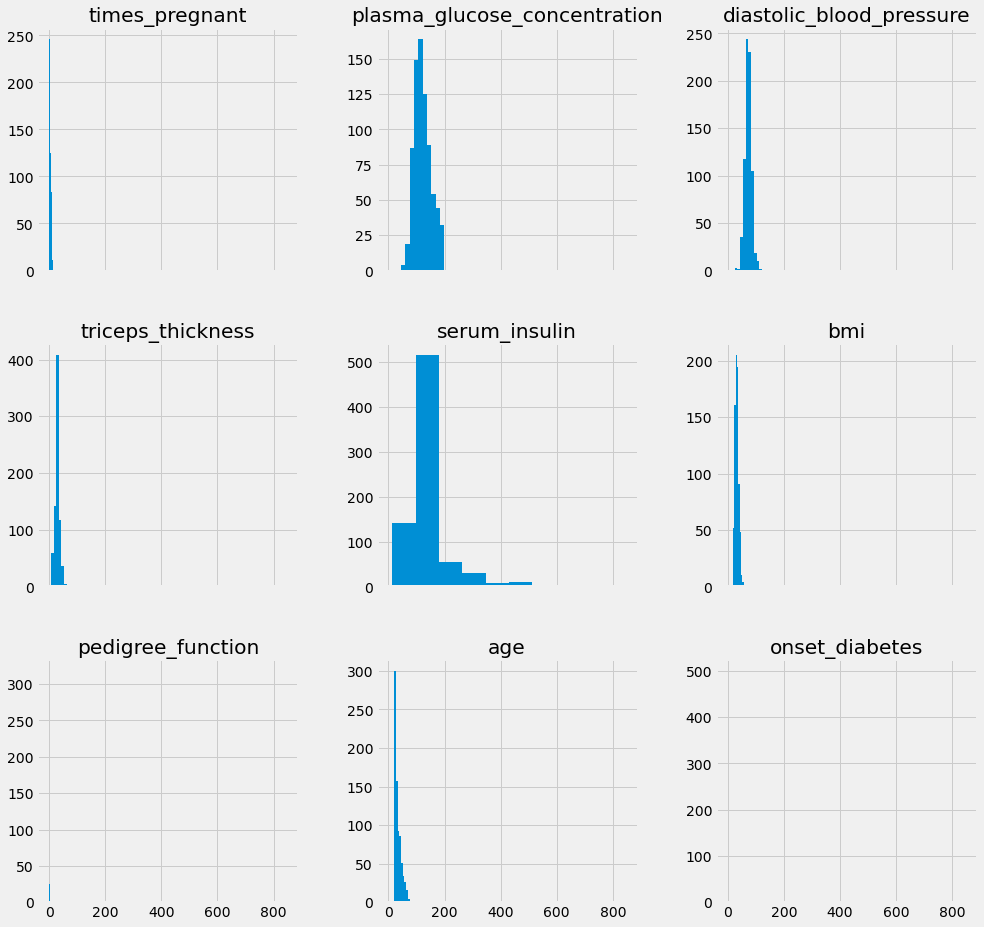

In [94]:
pima.hist(figsize=(15, 15), sharex=True)
plt.show()

It is quite clear that our data all lives on vastly different scales. Data engineers have options on how to deal with this problem in our machine learning pipelines that are under a family of operations called normalization. Normalization operations are meant to align and transform both columns and rows to a consistent set of rules. For example, a common form of normalization is to transform all quantitative columns to be between a consistent and static range of values (for example all values must be between 0 and 1). We may also impose mathematical rules such as, all columns must have the same mean and standard deviation so that they appear nicely on the same histogram (unlike the pima histograms we computed recently). Normalization techniques are meant to level the playing field of data by ensuring that all rows and columns are treated equally under the eyes of machine learning.

We will focus on three methods of data normalization:
1. Z-score standardization
2. Min-max scaling
3. Row normalization

The first two deal specifically with altering features in place, while the third option actually manipulates the rows of the data, but is still just as pertinent as the first two.

Z-score standardization
The most common of the normalization techniques, z-score standardization, utilizes a very simple statistical idea of a z-score. The output of a z-score normalization are features that are re-scaled to have a mean of zero and a standard deviation of one. By doing this, by re-scaling our features to have a uniform mean and variance (square of standard deviation), then we allow models such as KNN to learn optimally and not skew towards larger scaled features. The formula is simple: for every column, we replace the cells with the following value:

z = (x - μ) / σ

Where:
1. z is our new value (z-score)
2. x is the previous value of the cell
3. μ is the mean of the column
4. σ is the standard deviation of the columns

In [95]:
print (pima['plasma_glucose_concentration'].head())

0     85.0
1    183.0
2     89.0
3    137.0
4    116.0
Name: plasma_glucose_concentration, dtype: float64


In [96]:
# get the mean of the column
mu = pima['plasma_glucose_concentration'].mean()

# get the standard deviation of the column
sigma = pima['plasma_glucose_concentration'].std()

# calculate z scores for every value in the column.
print (((pima['plasma_glucose_concentration'] - mu) / sigma).head())

0   -1.202617
1    2.013748
2   -1.071337
3    0.504025
4   -0.185196
Name: plasma_glucose_concentration, dtype: float64


We see that every single value in the column will be replaced, and also notice how now some of them are negative. This is because the resulting values represent a distance from the mean. So, if a value originally was below the mean of the column, the resulting z-score will be negative. Of course, in scikit-learn, we have built-in objects 

Text(0.5, 1.0, 'Distribution of plasma_glucose_concentration')

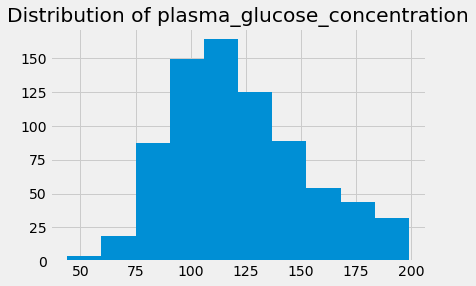

In [97]:
# mean and std before z score standardizing
pima['plasma_glucose_concentration'].mean(), pima['plasma_glucose_concentration'].std()

(121.68676277850591, 30.435948867207657)


ax = pima['plasma_glucose_concentration'].hist()
ax.set_title('Distribution of plasma_glucose_concentration')

Here, we can see the distribution of the column before doing anything. Now, let's apply a z-score scaling

In [98]:
scaler = StandardScaler()

glucose_z_score_standardized = scaler.fit_transform(pima[['plasma_glucose_concentration']])
glucose_z_score_standardized.mean(), glucose_z_score_standardized.std()

(7.411136748475621e-17, 0.9999999999999999)

We can see that after we apply our scaler to the column, mean drops to very small value and our standard deviation is one. Furthermore, if we take a look at the distribution of values across our recently scaled data

Text(0.5, 1.0, 'Distribution of plasma_glucose_concentration after Z Score Scaling')

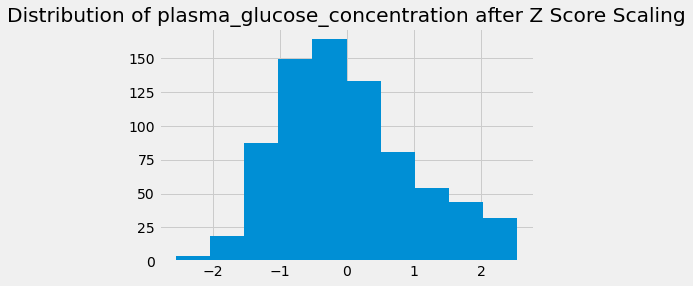

In [99]:
ax = pd.Series(glucose_z_score_standardized.reshape(-1,)).hist()
ax.set_title('Distribution of plasma_glucose_concentration after Z Score Scaling')

We will notice that our x axis is now much more constrained, while our y axis is unchanged. Also note that the shape of the data is unchanged entirely. Let's take a look at the histograms of our DataFrame after we apply a z-score transformation on every single column. When we do this, the StandardScaler will compute a mean and standard deviation for every column separately

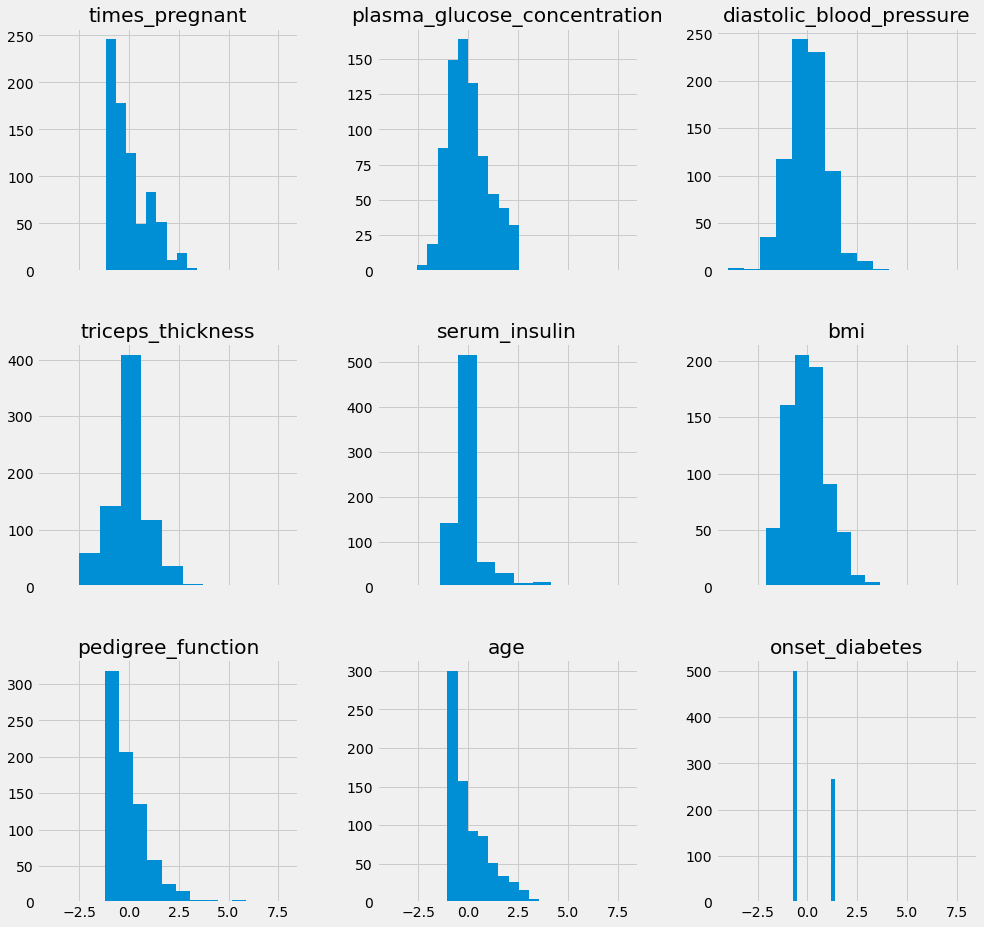

In [100]:
scale = StandardScaler() # instantiate a z-scaler object

pima_scaled = pd.DataFrame(scale.fit_transform(pima), columns=pima_column_names)
pima_scaled.hist(figsize=(15, 15), sharex=True)
plt.show()

In [131]:
mean_impute_standardize = Pipeline([('imputer', SimpleImputer()), ('standardize', StandardScaler()), ('classify', knn)])
X = pima.drop('onset_diabetes', axis=1)
y = pima['onset_diabetes']

knn_params = {'imputer__strategy':['mean', 'median'], 'classify__n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
grid = GridSearchCV(mean_impute_standardize, knn_params)
grid.fit(X, y_train)

print (grid.best_score_, grid.best_params_)

0.7826086956521738 {'classify__n_neighbors': 7, 'imputer__strategy': 'mean'}


Now we can clearly see our model has already started outperforming the benchmark. That's good progress we have till now

# The min-max scaling method
Min-max scaling is similar to z-score normalization in that it will replace every value in a column with a new value using a formula. In this case, that formula is:

m = (x -xmin) / (xmax -xmin)

Where:

1. m is our new value
2. x is the original cell value
3. xmin is the minimum value of the column
4. xmax is the maximum value of the column

In [102]:
min_max = MinMaxScaler()
pima_min_maxed = pd.DataFrame(min_max.fit_transform(pima), columns=pima_column_names)
pima_min_maxed.describe()

,times_pregnant,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_diabetes
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,0.226014,0.500921,0.493880,0.240023,0.153507,0.291066,0.168093,0.203651,0.348110
std,0.198287,0.196575,0.123632,0.096675,0.107155,0.140795,0.141545,0.195872,0.476682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.358065,0.408163,0.195652,0.106370,0.190184,0.070666,0.050000,0.000000
50%,0.176471,0.470968,0.489796,0.228261,0.106370,0.282209,0.125107,0.133333,0.000000
75%,0.352941,0.619355,0.571429,0.271739,0.186899,0.376278,0.233561,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Notice how the min are all zeros and the max values are all ones. Note further that the standard deviations are now all very very small, a side effect of this type of scaling. This can hurt some models as it takes away weight from outliers. Let's plug our new normalization technique into our pipeline

In [103]:
mean_impute_standardize = Pipeline([('imputer', SimpleImputer()), ('standardize', MinMaxScaler()), ('classify', knn)])
X = pima.drop('onset_diabetes', axis=1)
y = pima['onset_diabetes']

knn_params = {'imputer__strategy': ['mean', 'median'], 'classify__n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(mean_impute_standardize, knn_params)
grid.fit(X, y)

print (grid.best_score_, grid.best_params_)

0.7848399966047024 {'classify__n_neighbors': 7, 'imputer__strategy': 'mean'}


# The row normalization method
Our final normalization method works row-wise instead of column-wise. Instead of calculating statistics on each column, mean, min, max, and so on, the row normalization technique will ensure that each row of data has a unit norm, meaning that each row will be the same vector length. Imagine if each row of data belonged to an n-dimensional space; each one would have a vector norm, or length. Another way to put it is if we consider every row to be a vector in space:

1. x = (x1, x2, ..., xn)

Where 1, 2, ..., n in the case of Pima would be 8, 1 for each feature (not including the response), the norm would be calculated as: 

2. ||x|| = √(x12 + x22 + ... + xn2)

This is called the L-2 Norm. Other types of norms exist, but we will not get into that in this text. Instead, we are concerned with making sure that every single row has the same norm. This comes in handy, especially when working with text data or clustering algorithms.

Before doing anything, let's see the average norm of our mean-imputed matrix

In [105]:
np.sqrt((pima**2).sum(axis=1)).mean() 
# average vector length of imputed matrix

214.13592864897936

In [106]:
normalize = Normalizer()
pima_normalized = pd.DataFrame(normalize.fit_transform(pima), columns=pima_column_names)
np.sqrt((pima_normalized**2).sum(axis=1)).mean()
# average vector length of row normalized imputed matrix

1.0

After normalizing, we see that every single row has a norm of one now. Let's see how this method fares in our pipeline

In [107]:
mean_impute_normalize = Pipeline([('imputer', SimpleImputer()), ('normalize', Normalizer()), ('classify', knn)])
X = pima.drop('onset_diabetes', axis=1)
y = pima['onset_diabetes']

knn_params = {'imputer__strategy': ['mean', 'median'], 'classify__n_neighbors':[1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(mean_impute_normalize, knn_params)
grid.fit(X, y)

print (grid.best_score_, grid.best_params_)

0.8110092521857227 {'classify__n_neighbors': 7, 'imputer__strategy': 'mean'}


Not great, but worth a try. Now that we have seen three different methods of data normalization, let's put it all together and see how we did on this dataset.

There are many learning algorithms that are affected by the scale of data. Here is a list of some popular learning algorithms that are affected by the scale of data:

1. KNN- due to its reliance on the Euclidean Distance
2. K-Means Clustering - same reasoning as KNN
3. Logistic regression, SVM, neural networks — if you are using gradient descent to learn weights
4. Principal component analysis — eigen vectors will be skewed towards larger columns

In [115]:
def run_model(model,hyp,X,y,cv, Scaler):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=3)
    mean_impute_standardize = Pipeline([('imputer',SimpleImputer()),
                                       ('standardize_values',Scaler),
                                       ('classification',model)])
    
    grid = GridSearchCV(mean_impute_standardize,hyp,cv=cv)
    grid.fit(X_train,y_train)
    pred = grid.best_estimator_.predict(X_test)
    print(grid.best_params_)
    print(grid.best_estimator_)
    return metrics.accuracy_score(pred,y_test)

In [116]:
hyper_parameters = {'classification__penalty':['l1','l2'],'imputer__strategy':['mean','median']}
print('Logistic Regression accuracy: ')
run_model(LogisticRegression(solver='liblinear'),hyper_parameters,
          pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,MinMaxScaler())

Logistic Regression accuracy: 
{'classification__penalty': 'l1', 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', MinMaxScaler()),
                ('classification',
                 LogisticRegression(penalty='l1', solver='liblinear'))])


0.7467532467532467

In [117]:
hyper_parameters = {'classification__penalty':['l1','l2'],'imputer__strategy':['mean','median']}
print('Logistic Regression accuracy: ')
run_model(LogisticRegression(solver='liblinear'),hyper_parameters,
          pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,StandardScaler())

Logistic Regression accuracy: 
{'classification__penalty': 'l1', 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', StandardScaler()),
                ('classification',
                 LogisticRegression(penalty='l1', solver='liblinear'))])


0.7272727272727273

In [119]:
hyper_parameters = {'classification__criterion':['gini','entropy'],
                   'classification__n_estimators':[40,50,100,150,200],
                   'imputer__strategy':['mean','median']}
print('RandomForest Accuracy: ')
run_model(RandomForestClassifier(n_jobs=-1),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,MinMaxScaler())

RandomForest Accuracy: 
{'classification__criterion': 'entropy', 'classification__n_estimators': 150, 'imputer__strategy': 'median'}
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standardize_values', MinMaxScaler()),
                ('classification',
                 RandomForestClassifier(criterion='entropy', n_estimators=150,
                                        n_jobs=-1))])


0.8896103896103896

In [121]:
hyper_parameters = {'classification__criterion':['gini','entropy'],
                   'classification__n_estimators':[40,50,100,150,200],
                   'imputer__strategy':['mean','median']}
print('RandomForest Accuracy: ')
run_model(RandomForestClassifier(n_jobs=-1),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,StandardScaler())

RandomForest Accuracy: 
{'classification__criterion': 'gini', 'classification__n_estimators': 200, 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', StandardScaler()),
                ('classification',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1))])


0.8831168831168831

In [123]:
hyper_parameters = {'classification__kernel':['rbf','sigmoid','poly'],
                   'classification__C':[0.1,0.001,0.3,1],
                   'imputer__strategy':['mean','median']}
print('SupportVectorClassifier Accuracy: ')
run_model(SVC(),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,MinMaxScaler())

SupportVectorClassifier Accuracy: 
{'classification__C': 1, 'classification__kernel': 'poly', 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', MinMaxScaler()),
                ('classification', SVC(C=1, kernel='poly'))])


0.8376623376623377

In [124]:
hyper_parameters = {'classification__kernel':['rbf','sigmoid','poly'],
                   'classification__C':[0.1,0.001,0.3,1],
                   'imputer__strategy':['mean','median']}
print('SupportVectorClassifier Accuracy: ')
run_model(SVC(),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,StandardScaler())

SupportVectorClassifier Accuracy: 
{'classification__C': 1, 'classification__kernel': 'rbf', 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', StandardScaler()),
                ('classification', SVC(C=1))])


0.8051948051948052

In [125]:
hyper_parameters = {'classification__p':[1.3,1.5,2],
                   'classification__n_neighbors':[5,7,8,9],
                   'classification__weights':['uniform','distance'],
                    'imputer__strategy':['mean','median']}
print('KNeighborClassifier accuracy: ')
run_model(KNeighborsClassifier(n_jobs=-1),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,MinMaxScaler())

KNeighborClassifier accuracy: 
{'classification__n_neighbors': 9, 'classification__p': 1.3, 'classification__weights': 'uniform', 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', MinMaxScaler()),
                ('classification',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=9, p=1.3))])


0.8181818181818182

In [126]:
hyper_parameters = {'classification__p':[1.3,1.5,2],
                   'classification__n_neighbors':[5,7,8,9],
                   'classification__weights':['uniform','distance'],
                    'imputer__strategy':['mean','median']}
print('KNeighborClassifier accuracy: ')
run_model(KNeighborsClassifier(n_jobs=-1),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,StandardScaler())

KNeighborClassifier accuracy: 
{'classification__n_neighbors': 8, 'classification__p': 1.3, 'classification__weights': 'distance', 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', StandardScaler()),
                ('classification',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=8, p=1.3,
                                      weights='distance'))])


0.8376623376623377

In [127]:
hyper_parameters = {'classification__learning_rate':[0.1,0.3,0.6,1],
                   'classification__n_estimators':[30,50,80,100],
                   'imputer__strategy':['mean','median']}
print('AdaBoostClassifier accuracy: ')
run_model(AdaBoostClassifier(),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,MinMaxScaler())

AdaBoostClassifier accuracy: 
{'classification__learning_rate': 0.3, 'classification__n_estimators': 80, 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', MinMaxScaler()),
                ('classification',
                 AdaBoostClassifier(learning_rate=0.3, n_estimators=80))])


0.8896103896103896

In [128]:
hyper_parameters = {'classification__learning_rate':[0.1,0.3,0.6,1],
                   'classification__n_estimators':[30,50,80,100],
                   'imputer__strategy':['mean','median']}
print('AdaBoostClassifier accuracy: ')
run_model(AdaBoostClassifier(),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,StandardScaler())

AdaBoostClassifier accuracy: 
{'classification__learning_rate': 0.3, 'classification__n_estimators': 80, 'imputer__strategy': 'mean'}
Pipeline(steps=[('imputer', SimpleImputer()),
                ('standardize_values', StandardScaler()),
                ('classification',
                 AdaBoostClassifier(learning_rate=0.3, n_estimators=80))])


0.8896103896103896

In [129]:
hyper_parameters = {'imputer__strategy':['mean','median'],
                   'classification__learning_rate':[0.1,0.3,0.5,1],
                    'classification__max_depth':[3,6,8],
                    'classification__n_estimators':[30,60,100,150]
                   }
print('GradientBoostingClassifier accuracy: ')
run_model(GradientBoostingClassifier(),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,MinMaxScaler())

GradientBoostingClassifier accuracy: 
{'classification__learning_rate': 0.3, 'classification__max_depth': 6, 'classification__n_estimators': 60, 'imputer__strategy': 'median'}
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standardize_values', MinMaxScaler()),
                ('classification',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            n_estimators=60))])


0.8766233766233766

In [130]:
hyper_parameters = {'imputer__strategy':['mean','median'],
                   'classification__learning_rate':[0.1,0.3,0.5,1],
                    'classification__max_depth':[3,6,8],
                    'classification__n_estimators':[30,60,100,150]
                   }
print('GradientBoostingClassifier accuracy: ')
run_model(GradientBoostingClassifier(),hyper_parameters,
         pima.drop(labels='onset_diabetes',axis=1),pima['onset_diabetes'],3,StandardScaler())

GradientBoostingClassifier accuracy: 
{'classification__learning_rate': 0.3, 'classification__max_depth': 6, 'classification__n_estimators': 100, 'imputer__strategy': 'median'}
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('standardize_values', StandardScaler()),
                ('classification',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6))])


0.8831168831168831